In [2]:
class Operad:
    def __init__(self):
        self.colors = {}
        self.operations = {}

    def add_color(self, name, prop={}):
        if t := self.colors.get(name):
            self.colors[name] = (t, prop)
        else:
            self.colors[name] = prop
        return name, t

    def add_operation(self, name, prop={}):
        self.operations[name] = prop
        return name


class Tree:
    def __init__(self, operation, trunk, branches, operad, root=False):
        self.root = root

        trunk, parent = operad.add_color(trunk, self)
        self.trunk = trunk
        if parent:
            parent.branches[trunk] = self
            self.depth = parent.depth + 1
        else:
            self.depth = 0
        self.branches = {
            operad.add_color(branch, self)[0]: uTree(branch, depth=self.depth)
            for branch in branches
        }
        self.node = operad.add_operation(operation, self)

    def print_edges(self):
        return "".join(
            [f"{str(self.trunk)}\n"]
            + [
                "\t" * (self.depth + 1) + f"{branch.print_edges()}\n"
                for branch in self.branches.values()
            ]
        )

    def print_nodes(self):
        return "".join(
            [f"{str(self.node)}\n"]
            + [
                "\t" * (self.depth + 1) + f"{branch.print_nodes()}\n"
                for branch in self.branches.values()
            ]
        )

    def __str__(self):
        return f"{self.node}({','.join(self.branches.keys())};{self.trunk})"

    def __repr__(self):
        return f"{self.node}({','.join(self.branches.keys())};{self.trunk})"


class uTree(Tree):
    def __init__(self, name, depth, root = False):
        self.trunk = name
        self.branches = {}
        self.node = None
        self.depth = depth
        self.root = root

In [3]:
import re
from functools import cmp_to_key
from copy import deepcopy
from collections import defaultdict

def string_to_tree_space(string, operad, sort=True):

    operads = []
    operations = string.split("|")
    if sort:
        operations = operationSorting(operations)
    regex = r"(.*)\((.*)\)"
    for i, operation in enumerate(operations):
        match = re.match(regex, operation)
        if not match:
            raise RuntimeError(f"Operation not defined correctly {operation}")
        operation, parameters = match.groups()
        branches, trunk = parameters.split(";")
        operads.append(Tree(operation, trunk, branches.split(",") if branches else [], operad, not i))
    return  operads[0], operad


def tree_space_to_string(tree_space):
    _, operad = tree_space
    return "|".join(str(tree) for tree in operad.operations.values())

def _recursive_str(tree, s):
    s.append(str(tree))
    for branch in tree.branches.values():
        if not isinstance(branch, uTree):
            _recursive_str(branch, s)
    return s

def tree_to_string(tree):
    operations = operationSorting(_recursive_str(tree, []))
    return "|".join(operations)

def extract_compare(item):
    regex = r"(.*)\((.*)\)"
    match = re.match(regex, item)
    if not match:
        raise RuntimeError(f"Operation not defined correctly {item}")
    _, parameters = match.groups()
    branches, trunk = parameters.split(";")
    return trunk, branches.split(",")
    

def operationSorting(arr):
    n = len(arr)
    items = [(extract_compare(e), e) for e in arr]

    i = 0
    while i<n:
        item1 = items[i]
        for j in range(i+1, n):
            item2 = items[j]
            if item1[0][0] in item2[0][1]:
                items.pop(i)
                items.insert(j, item1)
                break
        else:
            i += 1
    return list(map(lambda x: x[1], items))


# S = string_to_tree_space("o0w(1,2;0)", Operad())
# T = string_to_tree_space("o0b(b,c;a)|o1b(d;b)", Operad())
S = string_to_tree_space("0W(1;0)|1W(2,3;1)", Operad())
T = string_to_tree_space("0B(b,d;a)|1B(c;b)", Operad())
# S = string_to_tree_space("0W(1;0)|1W(2,3;1)", Operad())
# T = string_to_tree_space("0B(b,d;a)|1B(c;b)|2B(e;d)", Operad())
# S = string_to_tree_space("o0w(1;0)", Operad())
# T = string_to_tree_space("o0b(b;a)", Operad())
# T = string_to_tree_space("o0w(c2,c1;c0)|o1w(c3,c4;c1)|o2w(c5,c6;c2)", Operad())
# S = string_to_tree_space("o0b(d2,d1;d0)|o1b(d3,d4;d1)|o2b(d5,d6;d2)", Operad())
# S = string_to_tree_space("W(b,c;a)", Operad())
# T = string_to_tree_space("B(1;0)", Operad())
# S = string_to_tree_space("0W(1;0)|1W(2,3;1)", Operad())
# T = string_to_tree_space("0B(b,d;a)|1B(c;b)|2B(e;d)", Operad())
# S = string_to_tree_space("0W(1;0)|1W(2,4,6;1)|2W(3;2)|3W(5;4)|4W(7;6)", Operad())
# T = string_to_tree_space("0B(b,f;a)|1B(c;b)|2B(d;c)|3B(e;d)|4B(g;f)", Operad())
# S = string_to_tree_space("0W(1;0)|1W(2,3;1)|2W(;3)", Operad())
# T = string_to_tree_space("0B(b,c;a)|1B(;c)", Operad())
# S = string_to_tree_space("0W(1;0)|1W(2,3;1)", Operad())
# T = string_to_tree_space("0B(b,c;a)", Operad())

# print(tree_space_to_string(S))
# print(tree_to_string(S[0]))
# print(tree_space_to_string(T))
# print(tree_to_string(T[0]))
# print(S[0].print_nodes())

In [4]:
class TreeMerger:
    def __init__(self, S, T):
        self.S_og_space = S
        self.T_og_space = T
        self.tree_str = self.merge(deepcopy(S[0]),deepcopy(T[0]))
        
    def get_result(self):
        return self.tree_str, self.S_og_space[1].operations, self.T_og_space[1].operations

    def merge(self, S, T):
        self.add_color_base(S, T.trunk)        
        return tree_to_string(S)
        
    def add_color_edge(self, T, c, depth):
        T.trunk = f"{c}-{T.trunk}"
        T.branches = self.rename_keys(T, c, True)
        T.depth += depth
        for Ti in T.branches.values():
            self.add_color_edge(Ti, c, depth)
        return T

    def rename_keys(self, S, c, inv=False):
        aux = {}
        for i, Si in S.branches.items():
            if not inv:
                aux[f"{i}-{c}"] = Si
            else:
                aux[f"{c}-{i}"] = Si
        return aux

    def add_color_base(self, S, c):
        S.trunk = f"{S.trunk}-{c}"
        S.branches = self.rename_keys(S, c)
        for i, Si in S.branches.items():
            if isinstance(Si, uTree):
                S.branches[i] = self.add_color_edge(
                    deepcopy(self.T_og_space[0]), i.split("-")[0], S.depth + 1
                )
            else:
                self.add_color_base(Si, c)
        
s = TreeMerger(deepcopy(S), deepcopy(T))
result = s.get_result()
print(result)

('0W(1-a;0-a)|1W(2-a,3-a;1-a)|0B(2-b,2-d;2-a)|1B(2-c;2-b)|0B(3-b,3-d;3-a)|1B(3-c;3-b)', {'0W': 0W(1;0), '1W': 1W(2,3;1)}, {'0B': 0B(b,d;a), '1B': 1B(c;b)})


In [5]:
class TreeManipulator:
    def __init__(self, tree_str, S_og_operations, T_og_operations, operad):
        self.tree_str = tree_str
        self.S_og_operations = S_og_operations
        self.T_og_operations = T_og_operations
        self.tree, self.operad = string_to_tree_space(tree_str, operad)

    def find_percolant_branches(self, S=None, found=[]):
        if not S:
            S = self.tree
        if S.node in self.S_og_operations.keys():
            if any(
                branch.node in self.T_og_operations.keys()
                for branch in S.branches.values()
            ):
                found.append(S)

        for Si in S.branches.values():
            self.find_percolant_branches(Si, found)
        return found

    def make_percolation(self, location):
        operations = self.tree_str.split("|")
        branches = list(location.branches.values())
        new_node = branches[0].node
        old_node = location.node
        to_change = [str(location)] + [str(branch) for branch in branches]
        old_operation = self.S_og_operations[old_node]
        new_operation = self.T_og_operations[new_node]

        morfed = []
        for _, c in new_operation.branches.items():
            morfed.append(
                f"{old_operation.node}({','.join(map(lambda x: x+'-'+c.trunk, old_operation.branches.keys()))};{old_operation.trunk}-{c.trunk})"
            )
        morfed.append(
            f"{new_operation.node}({','.join(map(lambda x: old_operation.trunk+'-'+x, new_operation.branches.keys()))};{old_operation.trunk}-{new_operation.trunk})"
        )

        for branch in to_change:
            operations.remove(branch)
        operations += morfed
        operations = operationSorting(operations)
        new_tree = "|".join(operations)
        return new_tree


tm = TreeManipulator(*result, Operad())
print(tm.find_percolant_branches())
tm.make_percolation(tm.find_percolant_branches()[0])


[1W(2-a,3-a;1-a)]


'0W(1-a;0-a)|0B(1-b,1-d;1-a)|1W(2-d,3-d;1-d)|1W(2-b,3-b;1-b)|1B(2-c;2-b)|1B(3-c;3-b)'

In [6]:
class ShuffleLattice:
    def __init__(self, S, T):
        self.tm = TreeMerger(deepcopy(S), deepcopy(T))
        self.initial_tree, *self.operations = self.tm.get_result()
        self.skeleton = defaultdict(list)
        self.initialize_skeleton()
        self.generate_shuffles()
        
    def initialize_skeleton(self):
        self.skeleton[self.initial_tree] = []

    def generate_shuffles(self):
        queue = []
        queue.append(self.initial_tree)

        while len(queue):
            tree = queue.pop()
            manipulator = TreeManipulator(tree, *self.operations, Operad())

            for location in  manipulator.find_percolant_branches(found=[]):
                fingerprint = manipulator.make_percolation(location)
                if not self.fingerprint_in_skeleton(fingerprint, tree):
                    queue.append(fingerprint)
                
    def fingerprint_in_skeleton(self, fingerprint, parent):
        operations = set(fingerprint.split("|"))
        found = False
        for key in self.skeleton:
            if operations == set(key.split("|")):
                self.skeleton[key].append(fingerprint)
                found = True
        if not found:
            self.skeleton[fingerprint].append(parent)
        return found
    

shl = ShuffleLattice(S, T)
# print([len(a) for a in shl.skeleton.values()])
# print("\n".join(shl.skeleton.keys()))
print("Number of trees:", len(shl.skeleton))
# print(shl.skeleton)
for i, tree in enumerate(shl.skeleton.keys()):
    print(f"R{i}")
    space = string_to_tree_space(tree, Operad())
    print(space[0].print_nodes())

Number of trees: 6
R0
0W
	1W
		0B
			1B
				None


			None


		0B
			1B
				None


			None




R1
0W
	0B
		1W
			1B
				None


			1B
				None



		1W
			None

			None




R2
0B
	0W
		1W
			1B
				None


			1B
				None




	0W
		1W
			None

			None




R3
0W
	0B
		1B
			1W
				None

				None



		1W
			None

			None




R4
0B
	0W
		1B
			1W
				None

				None




	0W
		1W
			None

			None




R5
0B
	1B
		0W
			1W
				None

				None




	0W
		1W
			None

			None






In [7]:
import random



def operationSorting(arr):
    n = len(arr)
    items = [(extract_compare(e), e) for e in arr]

    i = 0
    while i<n:
        item1 = items[i]
        for j in range(i+1, n):
            item2 = items[j]
            if item1[0][0] in item2[0][1]:
                items.pop(i)
                items.insert(j, item1)
                break
        else:
            i += 1
    return list(map(lambda x: x[1], items))


tree_str = "0W(1;0)|1W(2,4,6;1)|2W(3;2)|3W(5;4)|4W(7;6)"
operations = tree_str.split("|")
random.shuffle(operations)
print(operations)
print(operationSorting(operations))

# string_to_tree_space("|".join(operations), Operad())


['0W(1;0)', '2W(3;2)', '3W(5;4)', '4W(7;6)', '1W(2,4,6;1)']
['0W(1;0)', '1W(2,4,6;1)', '4W(7;6)', '3W(5;4)', '2W(3;2)']


{'root_a': (77.697, 453.0), '0B': (77.697, 366.0), '1B': (42.697, 279.0), '2B': (37.697, 192.0), '3B': (37.697, 105.0), 'leaf_e': (37.697, 18.0), '4B': (119.7, 279.0), 'leaf_g': (120.7, 192.0)}
{'root_a': (-322.303, 153.0), '0B': (-322.303, 66.0), '1B': (-357.303, -21.0), '2B': (-362.303, -108.0), '3B': (-362.303, -195.0), 'leaf_e': (-362.303, -282.0), '4B': (-280.3, -21.0), 'leaf_g': (-279.3, -108.0)}


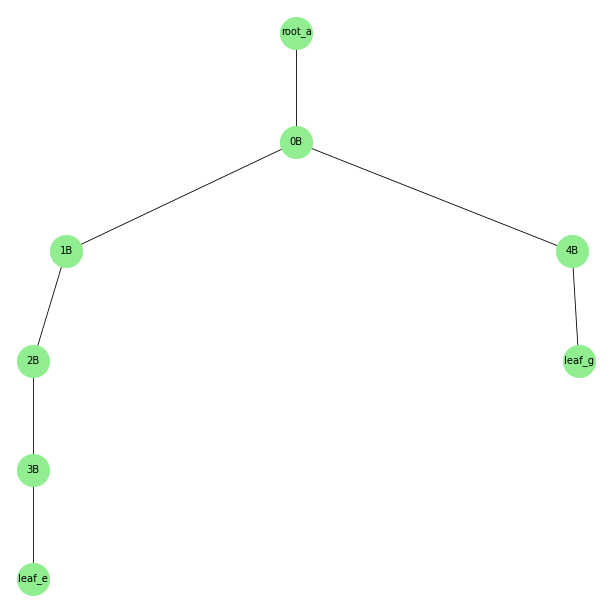

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

tree_str = "0B(b,f;a)|1B(c;b)|2B(d;c)|3B(e;d)|4B(g;f)" #"a(1;0)|b(2,4,6;1)|c(3;2)|d(5;4)|e(7;6)"
T = string_to_tree_space(tree_str, Operad())
G = nx.Graph()

def _recursive_add_edges(T, G):
    if T.root:
        s_n = f"root_{T.trunk}"
        t_n = T.node if T.node else f"leaf_{T.trunk}"
        G.add_edge(s_n, t_n, label=T.trunk)
    
    s_n = T.node
    for branch in T.branches.values():
        t_n = branch.node if branch.node else f"leaf_{branch.trunk}"
        G.add_edge(s_n, t_n, label=branch.trunk)
        _recursive_add_edges(branch, G)

# print(T)
_recursive_add_edges(T[0], G)
pos = graphviz_layout(G, prog="dot", root=None )

fig = plt.figure(1, figsize=(10, 10), dpi=60)

nx.draw(
    G, pos=pos, node_color="lightgreen", node_size=1500, with_labels=True, arrows=False, 
)
# nx.draw_networkx_edge_labels(
#     G, pos=pos, 
# )

print(pos)
yOffSet = -300
xOffSet = -400
for p in pos:
    pos[p] = (pos[p][0]+xOffSet,pos[p][1]+yOffSet)
print(pos)



In [16]:
import igraph as ig

tree_str = "uB(b,i;a)|vB(d;b)|rB(e,f;d)|sB(g,h;i)"
x_factor = 15
y_factor = 10

T = string_to_tree_space(tree_str, Operad(), sort=False)
G = ig.Graph()

def has_node(graph, name):
    try:
        graph.vs.find(name=name)
    except:
        return False
    return True


def _recursive_add_edges(T, G):
    if T.root:
        s_n = f"root_{T.trunk}"
        t_n = T.node if T.node else f"leaf_{T.trunk}"
        if not has_node(G, s_n):
            G.add_vertex(s_n, label=s_n)
        if not has_node(G, t_n):
            G.add_vertex(t_n, label=t_n)
        G.add_edge(s_n, t_n, label=T.trunk)
        
    if T.node:
        s_n = T.node
        if not has_node(G, s_n):
            G.add_vertex(s_n,label=s_n)
        for branch in T.branches.values():
            t_n = branch.node if branch.node else f"leaf_{branch.trunk}"
            if not has_node(G, t_n):
                G.add_vertex(t_n, label=t_n)
            G.add_edge(s_n, t_n, label=branch.trunk)
            _recursive_add_edges(branch, G)

# print(T)
_recursive_add_edges(T[0], G)
layout = G.layout_reingold_tilford(mode="in", root=[0] )
# print(layout.coords)
# print(G.vs()["name"])
vertices = list(zip(G.vs()["name"],layout.coords))
# print(vertices)
edges = list((e["label"],e.tuple) for e in G.es)
# print(edges)

layout = layout.scale(1)
ig.plot(G, layout=layout, )


multiplied = list(map(lambda x: (x[0], (round(x[1][0]*x_factor,2), round(x[1][1]*y_factor,2))), vertices))
# print(multiplied)

def node_name(name):
    if "W" in name:
        return "*{\\circ}"
    if "B" in name:
        return "*=0{\\bullet}"
    return "*{}"
print("\\xy")
print("<0.08cm, 0cm>:")

print("%Vertices%")
for i, vertex in enumerate(multiplied):
    print(str(vertex[1]) + node_name(vertex[0])+f"=\"{(i+1)}\"; %{vertex[0]}")

print("%Edges%")
for _, edge in edges:
    print(f'"{edge[0]+1}";"{edge[1]+1}"' +' **\dir{-};')

def get_label(name):
    if "root" in name or "leaf" in name:
        return None
    return name.strip("B").strip("W")
    
print("%Labels%")
for i, vertex in enumerate(multiplied):
    pos = (vertex[1][0]+3, vertex[1][1])
    if name:= get_label(vertex[0]):
        print(str(pos) + '*=0{\\scriptstyle '+name+'};')

for name, (s, t) in edges:    
    s_pos = multiplied[s][1]
    t_pos = multiplied[t][1]
    bias_x = -2
    bias_y = 0
    pos = (round((s_pos[0]+t_pos[0])/2+bias_x, 2), round((s_pos[1]+t_pos[1])/2 +bias_y,2))
    print(str(pos) + '*=0{\\scriptstyle '+name+'};')
print("\\endxy")

\xy
<0.08cm, 0cm>:
%Vertices%
(0.0, 0.0)*{}="1"; %root_a
(0.0, 10.0)*=0{\bullet}="2"; %uB
(-11.25, 20.0)*=0{\bullet}="3"; %vB
(-11.25, 30.0)*=0{\bullet}="4"; %rB
(-18.75, 40.0)*{}="5"; %leaf_e
(-3.75, 40.0)*{}="6"; %leaf_f
(11.25, 20.0)*=0{\bullet}="7"; %sB
(3.75, 30.0)*{}="8"; %leaf_g
(18.75, 30.0)*{}="9"; %leaf_h
%Edges%
"1";"2" **\dir{-};
"2";"3" **\dir{-};
"3";"4" **\dir{-};
"4";"5" **\dir{-};
"4";"6" **\dir{-};
"2";"7" **\dir{-};
"7";"8" **\dir{-};
"7";"9" **\dir{-};
%Labels%
(3.0, 10.0)*=0{\scriptstyle u};
(-8.25, 20.0)*=0{\scriptstyle v};
(-8.25, 30.0)*=0{\scriptstyle r};
(14.25, 20.0)*=0{\scriptstyle s};
(-2.0, 5.0)*=0{\scriptstyle a};
(-7.62, 15.0)*=0{\scriptstyle b};
(-13.25, 25.0)*=0{\scriptstyle d};
(-17.0, 35.0)*=0{\scriptstyle e};
(-9.5, 35.0)*=0{\scriptstyle f};
(3.62, 15.0)*=0{\scriptstyle i};
(5.5, 25.0)*=0{\scriptstyle g};
(13.0, 25.0)*=0{\scriptstyle h};
\endxy
